# Conformal Prediction - A Practical Guide with MAPIE


## MAPIE Conformal Prediction


In [ ]:
!pip install mapie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Import libraries

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### MAPIE Classification


In [ ]:
from sklearn import naive_bayes
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score

In [ ]:
# Create a toy dataset with two features and 3 classes (0, 1, 2) with a bit of noise

n_samples = 1500
n_features = 2
n_classes = 3

X = np.random.randn(n_samples, n_features)
y = np.zeros(n_samples)

for i in range(n_classes):
    X[y == i] += np.random.randn(1, n_features) * 1.2

y = np.where(X[:, 0] > 0, 0, 1)
y = np.where(X[:, 1] > 0, y, y + 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Train a Gaussian Naive Bayes classifier

clf = naive_bayes.GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

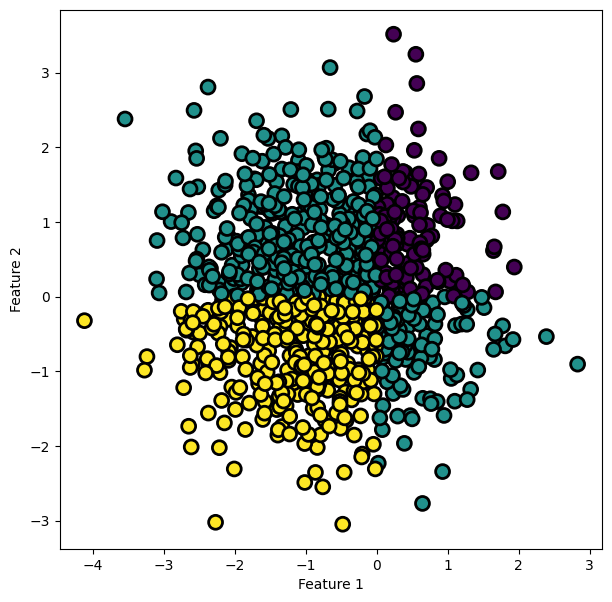

In [ ]:
# Plot the training set

plt.figure(figsize=(7, 7))
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    s=100,
    cmap="viridis",
    edgecolor="k",
    linewidth=2,
)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [ ]:
# Predict class labels and probabilities
y_pred_proba = clf.predict_proba(X_test)

# Calculate Softmax score
softmax_score = np.max(y_pred_proba, axis=1)

# Initialize the Conformal Prediction classifier
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
mapie_score.fit(X_cal, y_cal)

alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)

In [ ]:
# Taken from MAPIE docs
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=400,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}",
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

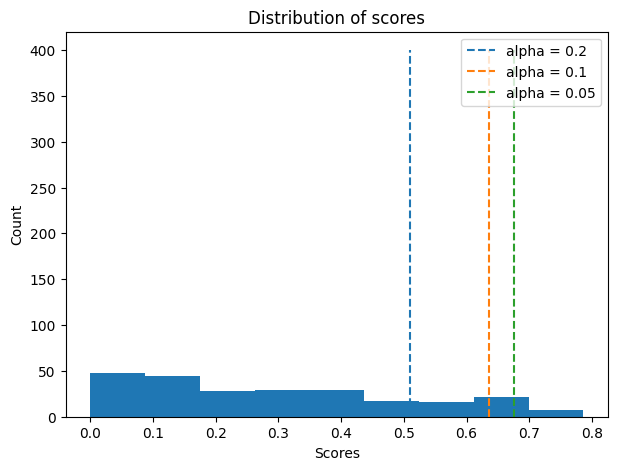

In [ ]:
# Plot the distribution of scores
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_

plot_scores(n, alpha, scores, quantiles)

<ipython-input-9-9d22b92071af>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = plt.cm.get_cmap("Purples", 4)


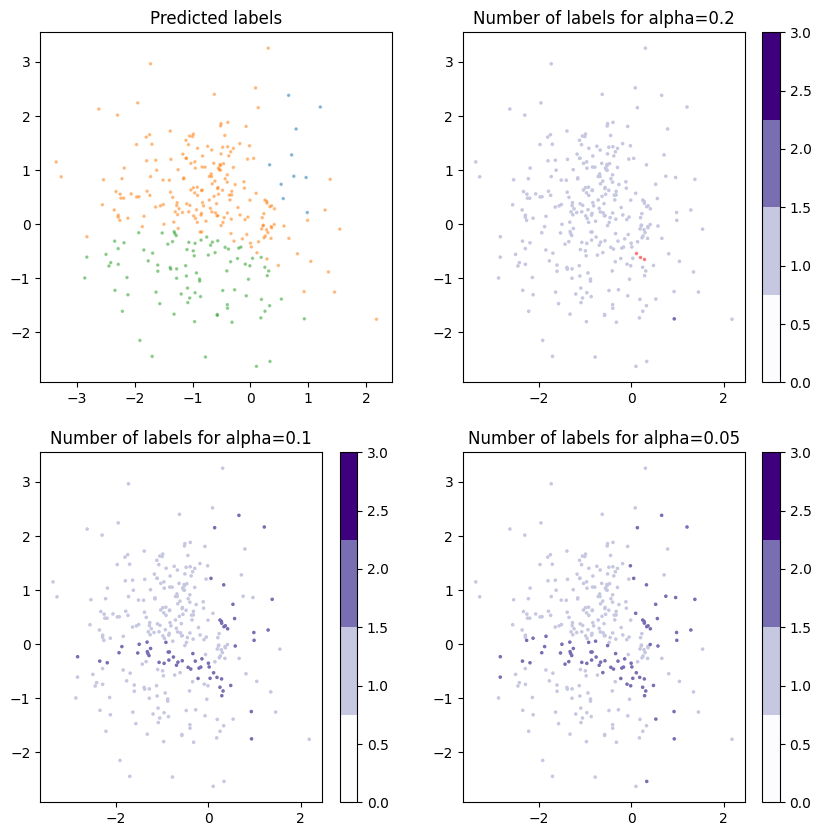

In [ ]:
# Taken and adapted from MAPIE docs


def plot_results(alphas, X, y_pred, y_ps):
    tab10 = plt.cm.get_cmap("Purples", 4)
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c", 3: "#d62728"}
    y_pred_col = list(map(colors.get, y_pred))
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))
    axs = {0: ax1, 1: ax2, 2: ax3, 3: ax4}
    axs[0].scatter(X[:, 0], X[:, 1], color=y_pred_col, marker=".", s=10, alpha=0.4)
    axs[0].set_title("Predicted labels")
    for i, alpha in enumerate(alphas):
        y_pi_sums = y_ps[:, :, i].sum(axis=1)
        num_labels = axs[i + 1].scatter(
            X[:, 0],
            X[:, 1],
            c=y_pi_sums,
            marker=".",
            s=10,
            alpha=1,
            cmap=tab10,
            vmin=0,
            vmax=3,
        )
        plt.colorbar(num_labels, ax=axs[i + 1])
        axs[i + 1].set_title(f"Number of labels for alpha={alpha}")

    # color regions where the label wasn't predicted in red
    for i, alpha in enumerate(alphas):
        y_pi_sums = y_ps[:, :, i].sum(axis=1)
        axs[i + 1].scatter(
            X[y_pi_sums == 0, 0],
            X[y_pi_sums == 0, 1],
            color="red",
            marker=".",
            s=10,
            alpha=0.4,
        )
    plt.show()


plot_results(alpha, X_test, y_pred_score, y_ps_score)

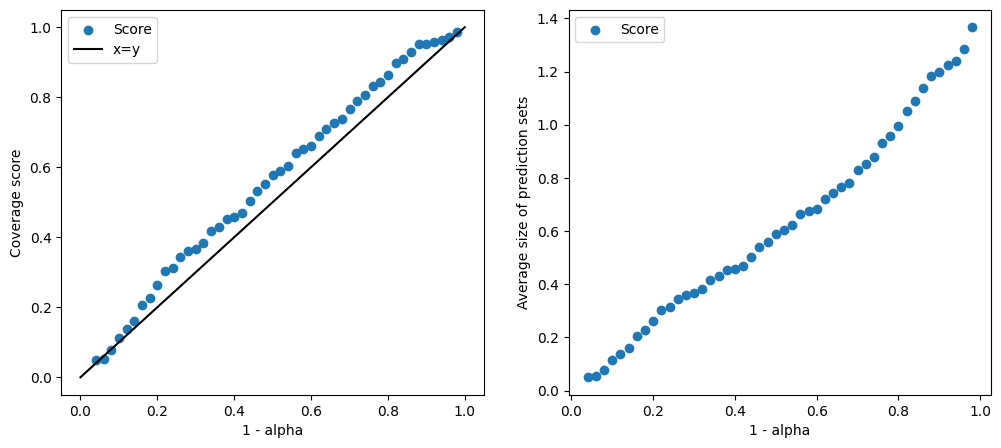

In [ ]:
alpha2 = np.arange(0.02, 0.98, 0.02)
_, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
coverages_score = [
    classification_coverage_score(y_test, y_ps_score2[:, :, i])
    for i, _ in enumerate(alpha2)
]
widths_score = [
    classification_mean_width_score(y_ps_score2[:, :, i]) for i, _ in enumerate(alpha2)
]


def plot_coverages_widths(alpha, coverage, width, method):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].scatter(1 - alpha, coverage, label=method)
    axs[0].set_xlabel("1 - alpha")
    axs[0].set_ylabel("Coverage score")
    axs[0].plot([0, 1], [0, 1], label="x=y", color="black")
    axs[0].legend()
    axs[1].scatter(1 - alpha, width, label=method)
    axs[1].set_xlabel("1 - alpha")
    axs[1].set_ylabel("Average size of prediction sets")
    axs[1].legend()
    plt.show()


plot_coverages_widths(alpha2, coverages_score, widths_score, "Score")

### MAPIE Quantile Regression


In [ ]:
!pip install lightgbm

In [ ]:
from mapie.quantile_regression import MapieQuantileRegressor
from lightgbm import LGBMRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score

In [ ]:
# import the diamonds dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/diamonds.csv"
)

# Create a train, calibration and test set
X = df.drop(["price"], axis=1)
# drop categorical variables for this example only
X = X.drop(["cut", "color", "clarity"], axis=1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_cal, X_test, y_cal, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

print(X_train.head())
print(y_train.head())

       carat  depth  table     x     y     z
26546   2.01   58.1   64.0  8.23  8.19  4.77
9159    1.01   60.0   60.0  6.57  6.49  3.92
14131   1.10   62.5   58.0  6.59  6.54  4.10
15757   1.50   61.5   65.0  7.21  7.17  4.42
24632   1.52   62.1   57.0  7.27  7.32  4.53
26546    16231
9159      4540
14131     5729
15757     6300
24632    12968
Name: price, dtype: int64


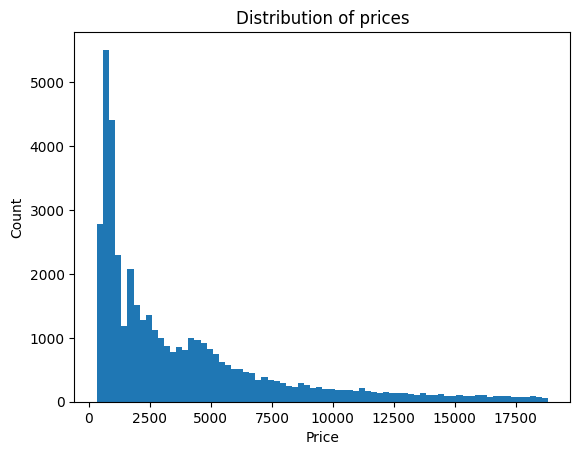

In [ ]:
# plot histogram of the target variable
plt.hist(y_train, bins="auto")
plt.title("Distribution of prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

In [ ]:
# taken from MAPIE docs


def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

# fit a Quantile LightGBM model
clf = LGBMRegressor(objective="quantile", alpha=0.05, random_state=42)

# optimize the model
params_distributions = dict(
    num_leaves=np.random.randint(10, 50, 11),
    max_depth=np.random.randint(3, 20, 6),
    n_estimators=np.random.randint(50, 300, 100),
    learning_rate=np.random.uniform(0.01, 0.1, 10),
)

optim_model = RandomizedSearchCV(
    clf,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=100,
    cv=KFold(n_splits=5, shuffle=True),
    verbose=-1,
)

optim_model.fit(X_train, y_train)
clf = optim_model.best_estimator_

In [ ]:
mapie = MapieQuantileRegressor(clf, method="quantile", cv="split", alpha=0.2)
mapie.fit(X_train, y_train)

# sort the data
y_pred, y_pis = mapie.predict(X_test)

(y_test_sorted, y_pred_sorted, lower_bound, upper_bound) = sort_y_values(
    y_test, y_pred, y_pis
)

# Calculate the coverage and width of the prediction intervals
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:67: FutureWarning: Class MapieQuantileRegressor is deprecated; WARNING: Deprecated path to import MapieQuantileRegressor. Please prefer the new path: [form mapie.regression import MapieQuantileRegressor].
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/mapie/utils.py:516: UserWarning: WARNING: The predictions of the quantile regression have issues.
The upper quantile predictions are lower
than the lower quantile predictions
at some points.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mapie/utils.py:534: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


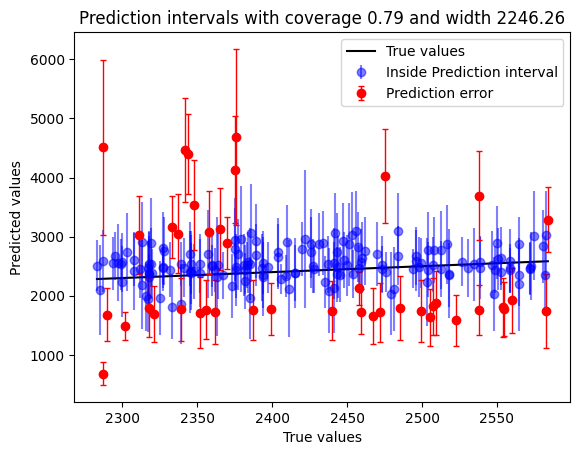

In [ ]:
#  take 10% of the data to make the plot more readable
y_test_sorted = y_test_sorted[2600:2800]
y_pred_sorted = y_pred_sorted[2600:2800]
lower_bound = lower_bound[2600:2800]
upper_bound = upper_bound[2600:2800]

# Prepare warnings when the prediction interval does not contain the true value
error = y_pred_sorted - lower_bound
warning1 = y_test_sorted > (y_pred_sorted + error)
warning2 = y_test_sorted < (y_pred_sorted - error)
warnings = warning1 + warning2

plt.plot(y_test_sorted, y_test_sorted, label="True values", color="black")

plt.errorbar(
    y_test_sorted[~warnings],
    y_pred_sorted[~warnings],
    yerr=error[~warnings],
    alpha=0.5,
    fmt="o",
    color="blue",
    label="Inside Prediction interval",
)

plt.errorbar(
    y_test_sorted[warnings],
    y_pred_sorted[warnings],
    yerr=error[warnings],
    fmt="o",
    color="red",
    ecolor="red",
    elinewidth=1,
    capsize=2,
    label="Prediction error",
)

plt.title(f"Prediction intervals with coverage {coverage:.2f} and width {width:.2f}")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.legend()
plt.show()

### MAPIE Time Series


In [ ]:
!pip install xgboost

In [ ]:
from mapie.time_series_regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from sklearn.model_selection import RandomizedSearchCV, KFold
import xgboost as xgb

In [ ]:
# load sales data
df = pd.read_csv("sales.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df.head()

,sales
date,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [ ]:
df.tail()

,sales
date,
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0
1975-11-01,797.0
1975-12-01,843.0


Text(0, 0.5, 'Sales')

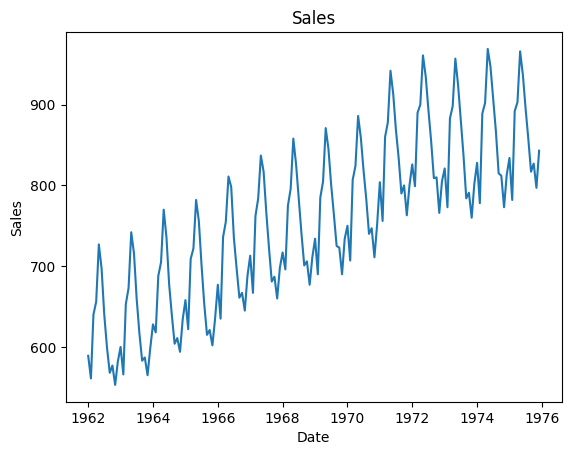

In [ ]:
# create features
df["month"] = df.index.month
df["year"] = df.index.year

# plot the data
plt.plot(df["sales"])
plt.title("Sales")
plt.xlabel("Date")
plt.ylabel("Sales")

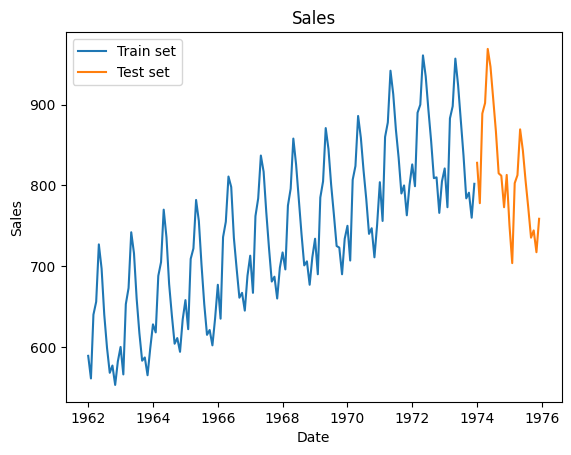

In [ ]:
# create train and test sets
X = df.drop(["sales"], axis=1)
y = df["sales"]

# split the data where test is eveyrthing after 1974
X_train = X[X.index.year < 1974]
X_test = X[X.index.year >= 1974]
y_train = y[y.index.year < 1974]
y_test = y[y.index.year >= 1974]

# introduce a change in seasonality after 1975 in the y_test set by applying a 10% drop
y_test.loc[y_test.index.year >= 1975] = y_test.loc[y_test.index.year >= 1975] * 0.9

# plot the data whole data and colored train and test sets
plt.plot(X_train.index, y_train, label="Train set")
plt.plot(X_test.index, y_test, label="Test set")
plt.title("Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, random_state=42)

# optimize the model
params_distributions = dict(
    max_depth=np.random.randint(3, 20, 1),
    learning_rate=np.random.uniform(0.01, 0.1, 10),
)

reg = RandomizedSearchCV(
    reg,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=10,
    cv=KFold(n_splits=5, shuffle=True),
    verbose=-1,
)

reg.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=N...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1000, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01844291, 0.0689051 , 0.03449128, 0.09736804, 0.04297779,
       0.07415311, 0.05554685, 0.04650575, 0.03661268, 0.01486112]),
                                        'max_depth': array([4])},
                   verbose=-1)

In [ ]:
# It's Confromal Prediction time!
alpha = 0.05
gap = 1

mapie_cv = BlockBootstrap(n_blocks=10, overlapping=True, random_state=42)

mapie_enbpi = MapieTimeSeriesRegressor(
    reg, method="enbpi", cv=mapie_cv, agg_function="mean", n_jobs=-1
)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:67: FutureWarning: Class MapieTimeSeriesRegressor is deprecated; WARNING: Deprecated path to import MapieTimeSeriesRegressor. Please prefer the new path: [form mapie.regression import MapieTimeSeriesRegressor].
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0])

In [ ]:
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit = []
lower_quantiles_pfit = []
higher_quantiles_pfit = []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap) : step, :],
        y_test.iloc[(step - gap) : step],
    )
    (
        y_pred_pfit[step : step + gap],
        y_pis_pfit[step : step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step : (step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0])

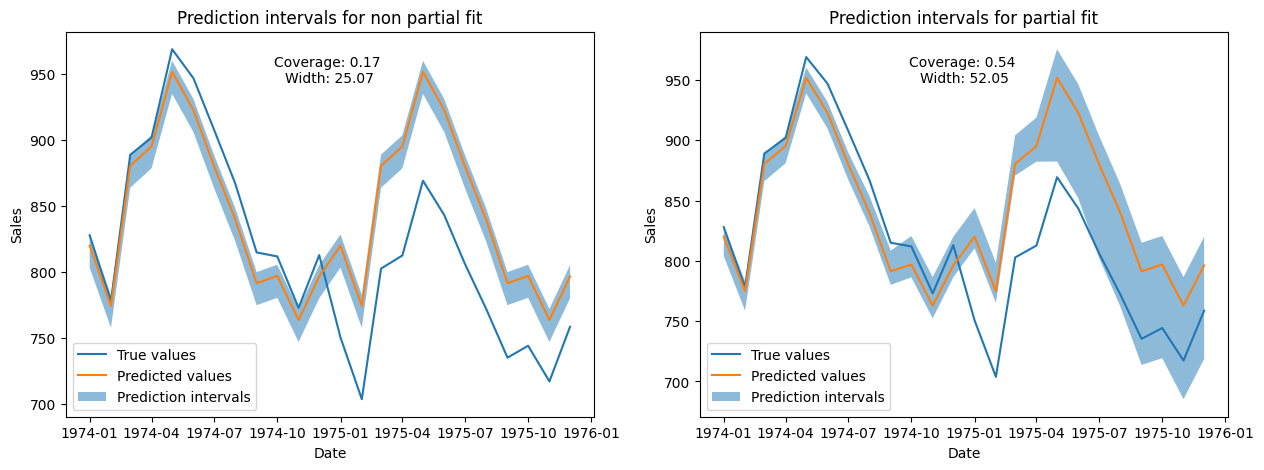

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(y_test.index, y_test, label="True values")
ax1.plot(y_test.index, y_pred_npfit, label="Predicted values")
ax1.fill_between(
    y_test.index,
    y_pis_npfit[:, 0, 0],
    y_pis_npfit[:, 1, 0],
    alpha=0.5,
    label="Prediction intervals",
)
ax1.set_title("Prediction intervals for non partial fit")
ax1.text(
    0.5,
    0.9,
    f"Coverage: {round(coverage_npfit,2 )} \nWidth: {round(width_npfit,2)}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax1.transAxes,
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.legend()

ax2.plot(y_test.index, y_test, label="True values")
ax2.plot(y_test.index, y_pred_pfit, label="Predicted values")
ax2.fill_between(
    y_test.index,
    y_pis_pfit[:, 0, 0],
    y_pis_pfit[:, 1, 0],
    alpha=0.5,
    label="Prediction intervals",
)
ax2.set_title("Prediction intervals for partial fit")
ax2.text(
    0.5,
    0.9,
    f"Coverage: {round(coverage_pfit,2)} \nWidth: {round(width_pfit, 2)}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.legend()